In [1]:
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import datasets
from nltk.corpus import stopwords
from nltk import bigrams
import nltk
import seaborn as sn
from collections import Counter, defaultdict
from gensim.sklearn_api.w2vmodel import W2VTransformer
from gensim.sklearn_api.d2vmodel import D2VTransformer
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
import xlrd
import operator
import math
import openpyxl

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [3]:
# Importing data
df = pd.read_csv("Handelingen.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']


In [4]:
df['list_text'] = df.text.apply(lambda x: [stemmer.stem(t) for t in tokenizer.tokenize(x)])
df['normal_text'] = df.list_text.apply(lambda x: ' '.join(x))
df.head(5)

,surname,party,text,file,speech category,date,tags,list_text,normal_text
107136,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[mevrouw, de, voorzitter, dit, kabinet, heeft,...",mevrouw de voorzitter dit kabinet heeft ons mo...
107137,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[voorzitter, vorig, wek, plaatst, werkgever, w...",voorzitter vorig wek plaatst werkgever werknem...
107138,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[voorzitter, twee, maand, geled, kreg, dit, ka...",voorzitter twee maand geled kreg dit kabinet v...
107139,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[voorzitter, allen, al, in, de, eerst, drie, m...",voorzitter allen al in de eerst drie maand van...
107148,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[voorzitter, we, zijn, eruit, eerst, ontdekt, ...",voorzitter we zijn eruit eerst ontdekt de mini...


# Data Info

In [5]:
# Creates a dataframe with counts of dataset per party
countdf = df.party.value_counts().sort_index()
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=False))
countdf

50PLUS           413
CDA             2216
ChristenUnie    1223
D66             2211
GroenLinks      1193
PVV             1880
PvdA            2269
PvdD             480
SGP              770
SP              2573
VVD             2157
Name: party, dtype: int64

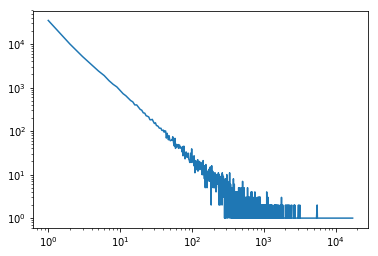

In [6]:
tekst = chain.from_iterable([list(set(doc)) for doc in df.list_text])
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

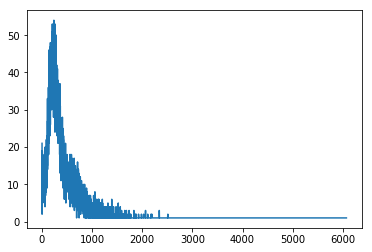

In [7]:
t = Counter([len(doc) for doc in df.list_text])
t = sorted(t.items())
x, y = zip(*t)
plt.plot(x, y)
plt.show()

# Mutual Info

In [8]:
# text_dict = {x: y for x, y in zip(df.index, df.list_text)}
# class_dict = defaultdict(list)

# for x,y in zip(df.party, df.index):
#     class_dict[x].append(y)
    
# enddoc = defaultdict(lambda : defaultdict(int))
# totaldocs = 0
# lijst = []
# setnormalized = {doc: list(set(words)) for doc, words in text_dict.items()}
# for c, dlist in class_dict.items():
#     totaldocs += len(dlist)
#     for doc in dlist:
#         for word in setnormalized[doc]:
#             enddoc[word][c] += 1
#             enddoc[word]["total"] += 1
            
# def MU(word, c, enddoc, class_dict, totaldocs):
#     N = totaldocs
#     N11 = enddoc[word][c]
#     N01 = len(class_dict[c]) - N11
#     N10 = enddoc[word]["total"] - N11
#     N00 = N - N11 - N01 - N10
#     N21 = N11 + N01
#     N12 = N10 + N11
#     N02 = N01 + N00
#     N20 = N10 + N00
#     return ((N11 / N) * float(Decimal((N * N11) / (N12 * N21)).log10()) / math.log(2, 10) 
#         + (N01 / N) * float(Decimal((N * N01) / (N02 * N21)).log10()) / math.log(2, 10) 
#         + (N10 / N) * float(Decimal((N * N10) / (N12 * N20)).log10()) / math.log(2, 10) 
#         + (N00 / N) * float(Decimal((N * N00) / (N02 * N20)).log10()) / math.log(2, 10))
# enddoc = {c: {word : MU(word, c, enddoc, class_dict, totaldocs) for word in enddoc.keys()} 
#           for c in class_dict.keys()}
# mudf = pd.DataFrame.from_dict(enddoc)

In [9]:
# # Dit kan simpeler
# terms10 = {c: mudf[c].nlargest(10).to_dict() for c in class_dict}
# terms10x = {x:[p for p,q in sorted(y.items(), key=operator.itemgetter(1), reverse = True)] for x,y in terms10.items()}
# MIdf = pd.DataFrame(terms10x)
# MIdf

In [10]:
# with open("Verslag/Tables/MItable.tex", "w") as f:
#     f.write(MIdf.iloc[:,:5].to_latex(index=False))
# with open("Verslag/Tables/MItable2.tex", "w") as f:
#     f.write(MIdf.iloc[:,5:].to_latex(index=False))

# Models

In [11]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [12]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.RAW)}

In [13]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.list_text)
    else:
        text = list(df.normal_text)
        
    gs = GridSearchCV(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name
    pd.concat([rows, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("voltooid:%s" %name)
    
#https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with Standar

voltooid:SVC


# Best Score

In [22]:
# Select the classifier and parameters with highest score
scores = pd.read_csv('Scores.csv', index_col=0).head(1)
scores = scores.dropna(axis=1).reset_index(drop=True)
scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
models_df, models_dict = modelsdownload(False)
pipe = models_dict[scores.name[0]]
pipe.set_params(**scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0])

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=0.001,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [23]:
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.normal_text), list(df_train.party))
predicted = pipe.predict(df_test.normal_text)
print(classification_report(df_test.party, predicted))

              precision    recall  f1-score   support

      50PLUS       0.94      0.80      0.86        80
         CDA       0.78      0.74      0.76       416
ChristenUnie       0.75      0.69      0.72       229
         D66       0.70      0.69      0.69       422
  GroenLinks       0.81      0.69      0.74       233
         PVV       0.83      0.79      0.81       397
        PvdA       0.64      0.70      0.67       477
        PvdD       0.85      0.85      0.85        96
         SGP       0.77      0.80      0.78       172
          SP       0.72      0.77      0.74       520
         VVD       0.64      0.66      0.65       435

 avg / total       0.73      0.73      0.73      3477



In [40]:
pipe.named_steps['vect'].vocabulary_['wij']

29806

In [59]:
woord = pipe.named_steps['vect'].vocabulary_
inv_map = {v: k for k, v in woord.items()}
matrix = pipe.named_steps['SGD'].coef_
bla = []
for i in range(11):
    testlist = []
    test = matrix[i].argsort()[-10:][::-1]
    for t in test:
        testlist.append(inv_map[t])
    bla.append(testlist)
bla

[['50plus',
  'lid krol',
  'krol nar',
  'krol',
  'vor 50plus',
  'lid klein',
  'gepensioneerd',
  '50 plusser',
  'fractie 50plus',
  '50plus fractie'],
 ['cda',
  'cda fractie',
  'lid omtzigt',
  'led geurt',
  'led agnes',
  'lid geurt',
  'geurt',
  'keijzer',
  'omtzigt nar',
  'lid keijzer'],
 ['christenunie',
  'lid dik',
  'led voordewind',
  'led dik',
  'led seger',
  'led schout',
  'voordewind',
  'fractie christenunie',
  'dik faber',
  'faber'],
 ['d66',
  'led veldhov',
  'lid nar',
  'lid veldhov',
  'led bergkamp',
  'veldhov',
  'led schouw',
  'vor d66',
  'led weyenberg',
  'd66 vindt'],
 ['groenlink',
  'led voortman',
  'lid tonger',
  'lid voortman',
  'led tonger',
  'tonger',
  'voortman',
  'led klaver',
  'tonger nar',
  'grashoff'],
 ['pvv',
  'islamitisch',
  'klever',
  'lid graus',
  'graus',
  'graf',
  'lid beertema',
  'agema nar',
  'lid madlener',
  'pvv fractie'],
 ['pvda',
  'partij arbeid',
  'arbeid',
  'pvda fractie',
  'albert vries',
  'vo

In [25]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

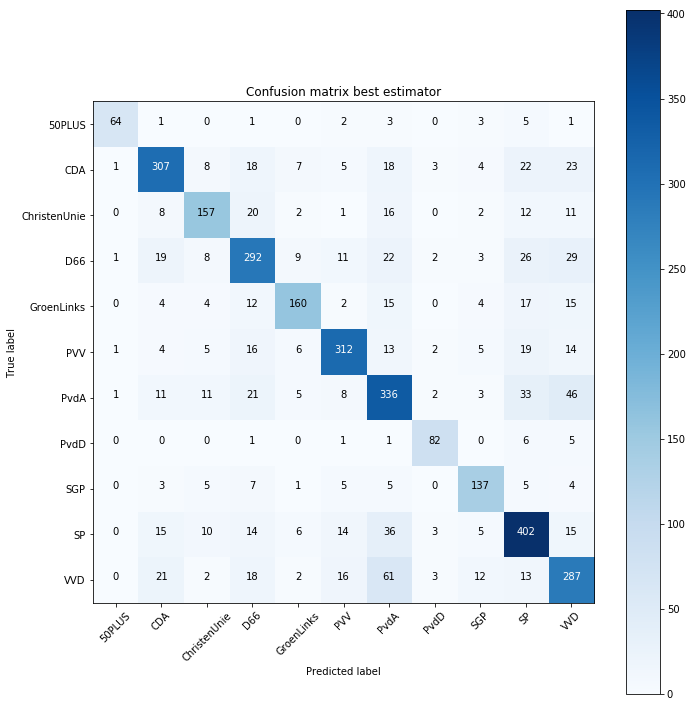

In [26]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix.png")
plt.show()

# Git

In [27]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MItable.tex
!git add Verslag/Tables/MItable2.tex
!git add Models.xlsx
!git add Verslag/confusionmatrix.png
!git commit -m Update
!git push

Already up to date.


The file will have its original line endings in your working directory.


[master b0f0dba] Update
 3 files changed, 54 insertions(+), 18 deletions(-)
 rewrite Models.xlsx (99%)
 rewrite Verslag/confusionmatrix.png (98%)


To https://github.com/jaspervdh96/Scriptie-Sprekers-TK.git
   a24ac01..b0f0dba  master -> master
